In [1]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from xmldic import bxml

from scipy.interpolate import griddata
from mpl_toolkits.basemap import Basemap
from getmedf import *

from datetime import datetime,timedelta

In [58]:
import pyresample

In [2]:
%matplotlib notebook

In [3]:
def pres(r):
    return pch+dph*np.exp(-(rmaxh/r)**bh)

# r = radius
# pch = Central Pressure (Pc)
# dph = Pressure Drop=(Pn-Pc)
# rmaxh = Radius of max winds (Rmax)
# bh = Holland's parameter (B)

In [4]:
def hvel(r):
    x=0.5+(r-rmaxh)/(maxR-rmaxh)*kh # manca min 
    return (bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**x

In [5]:
def hvel2d(l1,l2,vtx,vty):
    r=np.sqrt(l1**2+l2**2)
    
    xh=0.5+(r-rmaxh)/(maxR-rmaxh)*kh
    ur=(bh/rhoa*(rmaxh/r)**bh*dph*np.exp(-(rmaxh/r)**bh))**xh
    
    theta=np.arctan2(l2,l1)
    
    ux=-ur*np.sin(theta)
    uxs=ux+vtx*(1.-np.exp(-(rmaxh/r)**bh))
    
    uy=ur*np.cos(theta)
    uys=uy+vty*(1.-np.exp(-(rmaxh/r)**bh))

    return ux,uy,uxs,uys,pres(r)

In [6]:
from math import radians, cos, sin, asin, sqrt
def Haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6378.388 * c 
    m = km *1000 # to meters
    return  dlon,dlat,m

In [7]:
nm2m=1852. # 1 nautical mile to meters
kt2ms=nm2m/3600.  # knots to m/s
omega=2*np.pi/(3600.*24.) # angular speed omega=2pi*f(=frequency of earth : 1 cycle per day) 2pi* 1 / day in seconds
rhoa=1.15 #air density  Kg/m^3
radius=6378388 #137. # earth's radius according to WGS 84
deg2m=np.pi*radius/180.  # ds on cicle equals ds=r*dth - dth=pi/180
pn=101000.  # Atmospheric pressure [N/m^2] (101KPa - enviromental pressure)

tetaNE=45. #mean angle [degrees] of North Eastern quadrant
tetaNW=135. #        "              North Western
tetaSW=225. #        "              South West
tetaSE=315. #        "              South East

maxR=500.e3  # maximum radius of TC [m] (500Km)

In [8]:
GDACSdir='/DATA/critechuser/Notebooks/Tropical_Cyclones/TC_test/MALAKAS/Adv18/'

In [9]:
outfile=GDACSdir+'/outData.txt'

In [10]:
datH=pandas.read_csv(outfile,header=0,delimiter='\t',usecols=np.arange(0,16))

In [43]:
datH

,time,timemin,timesec,bul,forecast,xhc,yhc,vmax,vmax0,b,k,rmax,deltap,vtrx,vtry,catWind
0,0.0,0.0,0.0,1.0,0.0,144.7,12.8,15.432,8.03039,1.200000,0.000000,20000.0,620.377,-6.030950,1.28848,-1.0
1,6.0,360.0,21600.0,2.0,0.0,143.2,13.3,15.432,7.98325,1.200000,0.000000,20000.0,620.377,-6.018760,1.54617,-1.0
2,12.0,720.0,43200.0,3.0,0.0,141.7,13.1,20.576,19.52970,1.150020,0.023109,17542.3,1036.750,-6.274700,1.54617,0.0
3,18.0,1080.0,64800.0,4.0,0.0,140.5,13.7,20.576,19.09560,0.802720,0.141700,16498.8,1420.020,-6.759780,2.31926,0.0
4,24.0,1440.0,86400.0,5.0,0.0,139.0,14.2,20.576,18.95660,0.827521,0.147140,24437.3,1357.490,-6.745140,2.06156,0.0
5,30.0,1800.0,108000.0,6.0,0.0,137.8,14.3,23.148,19.39310,1.082780,0.012386,52188.4,1085.790,-6.242740,1.80387,0.0
6,36.0,2160.0,129600.0,7.0,0.0,136.8,14.5,23.148,19.39750,1.168160,0.029149,52182.5,1006.890,-5.987690,1.80388,0.0
7,42.0,2520.0,151200.0,8.0,0.0,135.5,14.7,25.720,19.26260,0.825214,0.117443,37861.8,1405.580,-5.982210,2.83464,0.0
8,48.0,2880.0,172800.0,9.0,0.0,134.5,14.9,30.864,27.00910,1.128960,0.061974,32722.4,2019.930,-6.225740,2.57695,0.0
9,54.0,3240.0,194400.0,10.0,0.0,133.0,15.5,30.864,27.16080,1.024160,0.022630,32094.5,2251.700,-6.208050,3.09233,0.0


In [31]:
datH.shape

(25, 16)

In [84]:
it=3

In [94]:
lonx=np.linspace(datH['xhc'][it]-5,datH['xhc'][it]+5,100)

In [95]:
latx=np.linspace(datH['yhc'][it]-5,datH['yhc'][it]+5,100)

In [96]:
qx,qy=np.meshgrid(lonx,latx) # degrees

In [97]:
rh=[]
dln=[]
dlt=[]
for lon1,lat1 in zip(qx.flatten(),qy.flatten()):
    dlon,dlat,ri = Haversine(lon1, lat1, datH['xhc'][it], datH['yhc'][it])
    rh.append(ri)
    dln.append(dlon)
    dlt.append(dlat)


In [98]:
rh=np.array(rh)
dln=np.array(dln)
dlt=np.array(dlt)


In [99]:
time=datH['time'][it]
bh=datH['b'][it]
vmaxh=datH['vmax'][it]
vmax0h=datH['vmax0'][it]
kh=datH['k'][it]
rmaxh=datH['rmax'][it]
dph=datH['deltap'][it]
pch=pn-dph
vtx=datH['vtrx'][it]
vty=datH['vtry'][it]

In [100]:
u=hvel(rh).reshape(100,100)

In [101]:
u.shape

(100, 100)

<IPython.core.display.Javascript object>


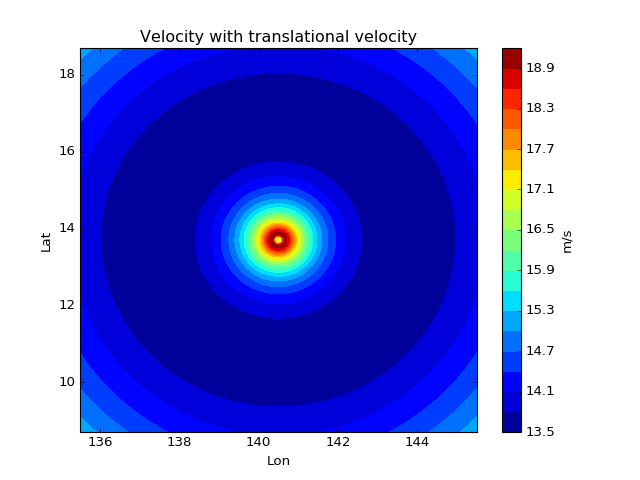

In [102]:
plt.figure(figsize=(8,6))
plt.contourf(qx,qy,u,20)
#plt.streamplot(q1/1000,q2/1000,zx,zy, color=maxvel, linewidth=0.1*vel)
plt.xlabel('Lon',fontsize=12)
plt.ylabel('Lat',fontsize=12)
plt.title('Velocity with translational velocity')
plt.colorbar(label='m/s')
    #plt.savefig(outdirplot+'/wind_cont_'+np.str(time)+'.png')


In [24]:
#2D
the=np.arctan2(dlat,dlon)

In [25]:
rx=-rh*np.sin(the)
ry=rh*np.cos(the)


In [26]:
#test
r=np.sqrt(rx**2+ry**2)
w=rh-r
print w.max(), w.min()


4.65661287308e-10 -4.65661287308e-10


In [27]:
# Calculate vel and pres
ux,uy, zx,zy, pr=hvel2d(rx,ry,vtx,vty)
utot=np.sqrt(ux**2+uy**2).reshape(100,100) # without translational velocity
#vel=np.sqrt(zx**2+zy**2)
cvel=np.sqrt(zx**2+zy**2).reshape(100,100)# with translational velocity


In [28]:
utot.max()

27.051998702375531

In [29]:
cvel.max()

26.170222901095048

<IPython.core.display.Javascript object>


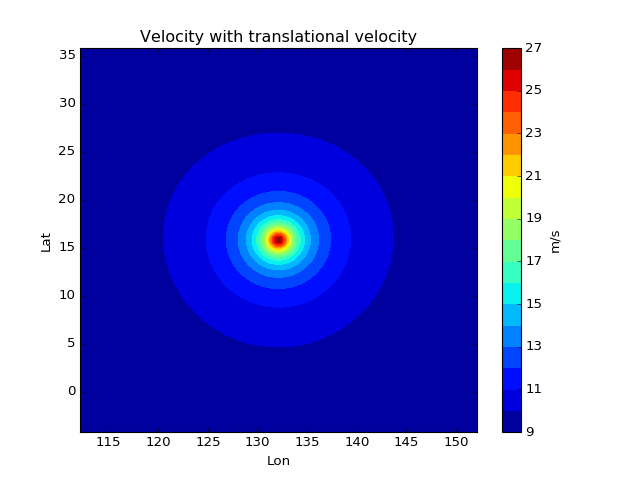

In [30]:
plt.figure(figsize=(8,6))
plt.contourf(qx,qy,cvel,20)
#plt.streamplot(q1/1000,q2/1000,zx,zy, color=maxvel, linewidth=0.1*vel)
plt.xlabel('Lon',fontsize=12)
plt.ylabel('Lat',fontsize=12)
plt.title('Velocity with translational velocity')
plt.colorbar(label='m/s')
    #plt.savefig(outdirplot+'/wind_cont_'+np.str(time)+'.png')


In [108]:
lx=np.linspace(datH['xhc'].mean()-30,datH['xhc'].mean()+30,1000)
ly=np.linspace(datH['yhc'].mean()-30,datH['yhc'].mean()+30,1000)
lons,lats=np.meshgrid(lx,ly) # degrees


In [112]:
cvelt=[]
utott=[]
for it in range(datH.shape[0]):
    
    lonx=np.linspace(datH['xhc'][it]-5,datH['xhc'][it]+5,500)
    latx=np.linspace(datH['yhc'][it]-5,datH['yhc'][it]+5,500)
    qx,qy=np.meshgrid(lonx,latx) # degrees
    rh=[]
    dln=[]
    dlt=[]
    for lon1,lat1 in zip(qx.flatten(),qy.flatten()):
        dlon,dlat,ri = Haversine(lon1, lat1, datH['xhc'][it], datH['yhc'][it])
        rh.append(ri)
        dln.append(dlon)
        dlt.append(dlat)
    rh=np.array(rh)
    dln=np.array(dln)
    dlt=np.array(dlt)
    time=datH['time'][it]
    bh=datH['b'][it]
    vmaxh=datH['vmax'][it]
    vmax0h=datH['vmax0'][it]
    kh=datH['k'][it]
    rmaxh=datH['rmax'][it]
    dph=datH['deltap'][it]
    pch=pn-dph
    vtx=datH['vtrx'][it]
    vty=datH['vtry'][it]
    the=np.arctan2(dlat,dlon)
    rx=-rh*np.sin(the)
    ry=rh*np.cos(the)
    ux,uy, zx,zy, pr=hvel2d(rx,ry,vtx,vty)
    utot=np.sqrt(ux**2+uy**2).reshape(500,500) # without translational velocity
    #vel=np.sqrt(zx**2+zy**2)
    cvel=np.sqrt(zx**2+zy**2).reshape(500,500)# with translational velocity
    wgeo=pyresample.geometry.SwathDefinition(lons=qx,lats=qy) # the wind grid geometry
    pgeo=pyresample.geometry.SwathDefinition(lons=lons,lats=lats) # the pop grid geometry
    air_near=pyresample.kd_tree.resample_nearest(wgeo,np.flipud(cvel),pgeo,radius_of_influence=500000,fill_value=0)
    cvelt.append(air_near)

In [113]:
#utott=np.array(utott)
cvelt=np.array(cvelt)

In [114]:
cvelt.shape

(25, 1000, 1000)

In [115]:
v=np.amax(cvelt,axis=0)

<IPython.core.display.Javascript object>


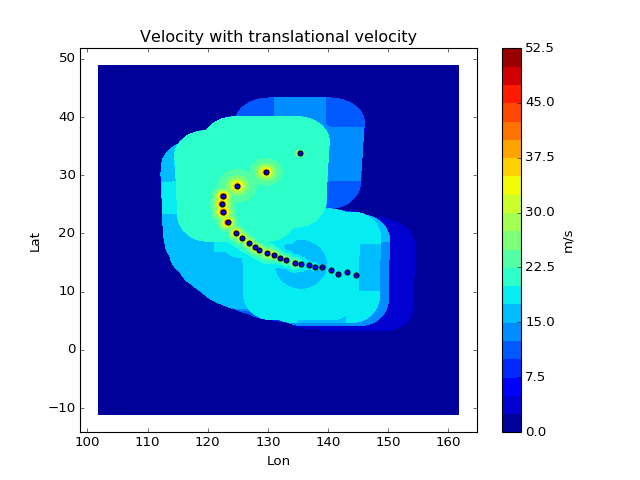

In [116]:
plt.figure(figsize=(8,6))
cf=plt.contourf(lons,lats,v,20)
#plt.streamplot(q1/1000,q2/1000,zx,zy, color=maxvel, linewidth=0.1*vel)
plt.scatter(datH['xhc'].values,datH['yhc'].values)
plt.xlabel('Lon',fontsize=12)
plt.ylabel('Lat',fontsize=12)
plt.title('Velocity with translational velocity')
plt.colorbar(cf,label='m/s')
    #plt.savefig(outdirplot+'/wind_cont_'+np.str(time)+'.png')
